# Check CSVs file to check the result

In [50]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plot
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import re

FPS = 15

In [51]:
CSVs = glob.glob('./results/*.csv')
CSVs

['./results\\10-10-2024_06-56-26_track_246_cam_0.avi_track_242_cam_3.avi.csv',
 './results\\10-10-2024_07-14-32_track_248_cam_0.avi_track_247_cam_4.avi.csv',
 './results\\10-10-2024_07-50-59_track_251_cam_0.avi_track_249_cam_5.avi.csv',
 './results\\10-10-2024_08-25-21_track_257_cam_0.avi_track_252_cam_8.avi.csv',
 './results\\10-10-2024_08-31-27_track_262_cam_0.avi_track_258_cam_9.avi.csv',
 './results\\10-10-2024_08-57-19_track_273_cam_0.avi_track_263_cam_11.avi.csv',
 './results\\10-10-2024_08-58-04_track_274_cam_0.avi_track_274_cam_12.avi.csv',
 './results\\10-10-2024_09-02-35_track_275_cam_0.avi_track_275_cam_13.avi.csv',
 './results\\10-10-2024_09-36-02_track_284_cam_0.avi_track_280_cam_15.avi.csv',
 './results\\10-10-2024_09-43-42_track_287_cam_0.avi_track_285_cam_16.avi.csv',
 './results\\10-10-2024_10-31-25_track_308_cam_0.avi_track_307_cam_26.avi.csv',
 './results\\10-10-2024_10-34-38_track_311_cam_0.avi_track_309_cam_27.avi.csv',
 './results\\10-10-2024_16-36-18_track_416_ca

In [52]:
def get_distance(value,dfDistance):
    # return vector of distances based on depth value
    vector_distances = []
    for i,track in dfDistance.iterrows():
        # print(track)
        # # coefs = eval(track['coefs'])
        # print(track['coefs'])
        # print(track['coefs'].split(']')[0].split('[')[-1], track['coefs'].split(']')[-2].split(' ')[-1])
        a = eval( track['coefs'].split(']')[0].split('[')[-1] )
        b = eval( track['coefs'].split(']')[-2].split(' ')[-1] )
        vector_distances.append( a*value + b )

    return vector_distances


['10-10-2024_09-02-35_track_275_cam_0.png']


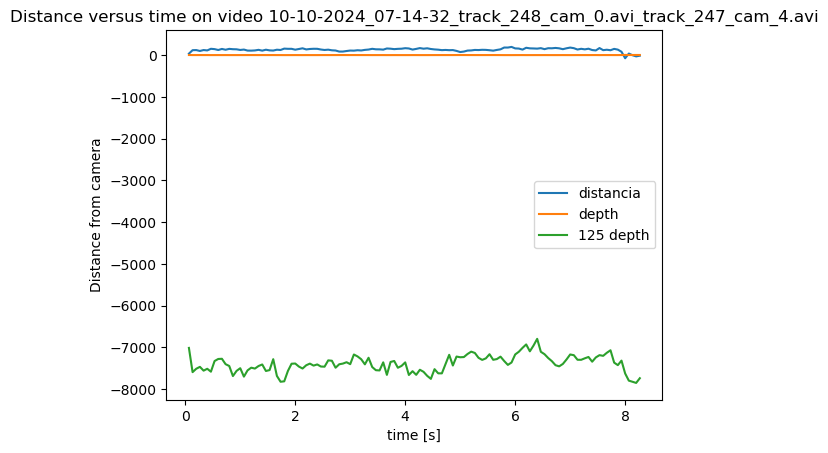

In [53]:
# Show the distance over time for a tracked bird
CSV = CSVs[1] # choose a CSV file


dfDistance = pd.read_csv(CSV)

for track_id in dfDistance['track_id'].unique():
    bMask = dfDistance['track_id']==track_id
    bird_distances = dfDistance[bMask]['bird_distance']
    bird_depths = dfDistance[bMask]['bird_Depth']
    time = dfDistance[bMask]['current_frame']/FPS
    # distance for depth = 125
    vector_distance125 = get_distance(125,dfDistance[bMask])


    print(dfDistance['ref_circles'].unique())
    # print(bird_distances)
    plot.plot(time,bird_distances)
    plot.plot(time,bird_depths)
    plot.plot(time, vector_distance125)
    plot.legend(["distancia","depth","125 depth"])
    plot.xlabel('time [s]')
    plot.ylabel('Distance from camera')
    plot.title("Distance versus time on video " + CSV.split('\\')[-1][:-4])
    plot.show()

## Metrics for Linear regression
| Metric | Explanation                                                   |
|:-------|:--------------------------------------------------------------|
| **RMSE**   | Root Mean Squared Error. Typical size of prediction errors (m). |
| **MAE**    | Mean Absolute Error. Average absolute error between prediction and ground truth (m). |
| **R²**     | Coefficient of determination. Fraction of variance explained (0–1). |
| **σ**      | Standard deviation of residuals. Spread of errors around zero (m). |



In [54]:
import os
import glob, re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

FPS = 15

def parse_ref_values(track_row):
    depths = [d[0] for d in eval(track_row['ref_depth_values'].replace('\n',','))]
    distances = eval(
        str(re.sub(r'\s+| ',',', track_row['ref_distance_values']))
            .replace('[,','[')
    )
    return np.array(depths), np.array(distances)

def fit_depth_to_distance_models(df):
    coefs = {}
    for track_id, sub in df.groupby('track_id'):
        D, Y = [], []
        for _, row in sub.iterrows():
            dpths, dists = parse_ref_values(row)
            dpths = 1/dpths
            D.append(dpths); Y.append(dists)
        X = np.concatenate(D).reshape(-1,1)
        y = np.concatenate(Y)
        reg = LinearRegression().fit(X, y)
        coefs[track_id] = (float(reg.coef_[0]), float(reg.intercept_))
    return coefs

def compute_regression_metrics(y_true, y_pred):
    y_true = np.ravel(y_true); y_pred = np.ravel(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred) if y_true.size >= 2 else np.nan
    sigma = np.std(y_true - y_pred)
    return rmse, mae, r2, sigma

# def main():
summary = []
for csv_path in glob.glob('./results/*.csv'):
    df = pd.read_csv(csv_path)
    df['time_s'] = df['current_frame'] / FPS

    # Fit depth→distance per track
    d2d_coefs = fit_depth_to_distance_models(df)
    coef_df = (
        pd.DataFrame.from_dict(d2d_coefs, orient='index', columns=['a','b'])
            .reset_index().rename(columns={'index':'track_id'})
    )
    df = df.merge(coef_df, on='track_id', how='left')
    # print(df['bird_Depth'].unique())
    df = df[df['bird_Depth']>0]
    df['pred_d2d'] = df['a'] * (1/df['bird_Depth']) + df['b']
    metrics_d, metrics_t = [], []

    # Per-track: metrics & plots
    for track_id, sub in df.groupby('track_id'):
        if len(sub) < 2:
            print(f"Track {track_id}: only {len(sub)} sample(s), skipping.")
            continue

        t = sub['time_s'].values.reshape(-1,1)
        y = sub['bird_distance'].values
        y_d = sub['pred_d2d'].values

        rmse_d, mae_d, r2_d, σ_d = compute_regression_metrics(y, y_d)
        metrics_d.append((rmse_d, mae_d, r2_d, σ_d))

        reg_t = LinearRegression().fit(t, y)
        y_t = reg_t.predict(t)
        rmse_t, mae_t, r2_t, σ_t = compute_regression_metrics(y, y_t)
        metrics_t.append((rmse_t, mae_t, r2_t, σ_t))

        # Plot
        bplot = False
        if bplot:
            plt.figure(figsize=(6,4))
            plt.scatter(t, y, s=20, label='Measured')
            plt.plot(t, y_d, '--', label='Depth→Distance')
            plt.plot(t, y_t, '-',  label='Time→Distance')
            plt.xlabel('Time [s]')
            plt.ylabel('Distance [m]')
            plt.title(f"{os.path.basename(csv_path)[:-4]} · Track {track_id}")
            plt.legend()
            plt.ylim(0, max(y.max(), y_d.max(), y_t.max())*1.1)
            plt.tight_layout()
            plt.show()

    # Compute per-file averages
    if metrics_d:
        avg_d = np.vstack(metrics_d).mean(axis=0)
        avg_t = np.vstack(metrics_t).mean(axis=0)
    else:
        avg_d = avg_t = (np.nan,)*4

    summary.append({
        'file': os.path.basename(csv_path),
        'RMSE_d': avg_d[0], 'MAE_d': avg_d[1], 'R2_d': avg_d[2], 'σ_d': avg_d[3],
        'RMSE_t': avg_t[0], 'MAE_t': avg_t[1], 'R2_t': avg_t[2], 'σ_t': avg_t[3]
    })

# Build summary table and add global average row
df_sum = pd.DataFrame(summary)
global_avg = df_sum.drop(columns='file').mean(numeric_only=True)
global_avg['file'] = 'AVERAGE'
df_sum = pd.concat([df_sum, global_avg.to_frame().T], ignore_index=True)

# Save the errors summary to a CSV file
#df_sum.to_csv('model_errors.csv', index=False)

# Print Markdown table
print(df_sum.to_markdown(index=False, floatfmt=".3f"))



Track 91.0: only 1 sample(s), skipping.
Track 153.0: only 1 sample(s), skipping.
Track 156.0: only 1 sample(s), skipping.
Track 492.0: only 1 sample(s), skipping.
Track 498.0: only 1 sample(s), skipping.
Track 581.0: only 1 sample(s), skipping.
Track 693.0: only 1 sample(s), skipping.
Track 699.0: only 1 sample(s), skipping.
| file                                                             |    RMSE_d |     MAE_d |           R2_d |       σ_d |   RMSE_t |   MAE_t |    R2_t |     σ_t |
|:-----------------------------------------------------------------|----------:|----------:|---------------:|----------:|---------:|--------:|--------:|--------:|
| 10-10-2024_06-56-26_track_246_cam_0.avi_track_242_cam_3.avi.csv  |   nan     |   nan     |        nan     |   nan     |  nan     | nan     | nan     | nan     |
| 10-10-2024_07-14-32_track_248_cam_0.avi_track_247_cam_4.avi.csv  |    25.520 |    19.301 |          0.578 |    22.867 |   39.173 |  25.843 |   0.007 |  39.173 |
| 10-10-2024_07-50-59

In [55]:
import os
import glob, re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

FPS = 15

def parse_ref_values(track_row):
    depths = [d[0] for d in eval(track_row['ref_depth_values'].replace('\n',','))]
    distances = eval(
        str(re.sub(r'\s+| ',',', track_row['ref_distance_values']))
            .replace('[,','[')
    )
    return np.array(depths), np.array(distances)

def compute_regression_metrics(y_true, y_pred):
    y_true = np.ravel(y_true);  y_pred = np.ravel(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred) if y_true.size >= 2 else np.nan
    sigma = np.std(y_true - y_pred)
    return rmse, mae, r2, sigma

# def main():
summary = []

for csv_path in glob.glob('./results/*.csv'):
    df = pd.read_csv(csv_path)
    df['time_s'] = df['current_frame'] / FPS
    
    # Ignore the rows when its "ignore" value is 1
    df = df[df['ignore'] != 1] # Added this line to filter the DataFrame       


    # Will accumulate per-track metrics for each model
    md_lin = []   # depth-linear
    md_hub = []   # depth-poly-huber
    mt_lin = []   # time-linear
    mt_hub = []   # time-poly-huber

    for track_id, sub in df.groupby('track_id'):
        # Gather measurement
        if len(sub) < 2:
            continue
        t = sub['time_s'].values.reshape(-1,1)
        y = sub['bird_distance'].values

        # — 1) Depth-Linear
        Z = sub['bird_Depth'].values.reshape(-1,1)
        mdl = LinearRegression().fit(Z, y)
        y_dl = mdl.predict(Z)
        md_lin.append(compute_regression_metrics(y, y_dl))

        # — 2) Depth-Poly-Huber
        md_h = make_pipeline(
            StandardScaler(),
            PolynomialFeatures(degree=2, include_bias=False),
            HuberRegressor(epsilon=1.35, max_iter=5000, tol=1e-4)
        )
        md_h.fit(Z, y)
        y_dh = md_h.predict(Z)
        md_hub.append(compute_regression_metrics(y, y_dh))

        # — 3) Time-Linear
        mtl = LinearRegression().fit(t, y)
        y_tl = mtl.predict(t)
        mt_lin.append(compute_regression_metrics(y, y_tl))

        # — 4) Time-Poly-Huber
        mt_h = make_pipeline(
            StandardScaler(),
            PolynomialFeatures(degree=2, include_bias=False),
            HuberRegressor(epsilon=1.35, max_iter=5000, tol=1e-4)
        )
        mt_h.fit(t, y)
        y_th = mt_h.predict(t)
        mt_hub.append(compute_regression_metrics(y, y_th))

        bPlot = False
        if bPlot:
            # — Plot all four fits
            fig, ax = plt.subplots(figsize=(9,4))

            # Plot the data and fits
            ax.scatter(t, y  ,       s=30, c='C0', edgecolor='k', label='Measured distances')
            ax.plot(   t, y_dl, '--', c='C1', linewidth=2, label='Depth – Linear')
            ax.plot(   t, y_dh, '-.', c='C2', linewidth=2, label='Depth – Quadratic + Huber')
            ax.plot(   t, y_tl, ':',  c='C3', linewidth=2, label='Time – Linear')
            ax.plot(   t, y_th, '-',  c='C4', linewidth=2, label='Time – Quadratic + Huber')

            ax.set_xlabel('Time [s]')
            ax.set_ylabel('Distance [m]')
            ax.set_title(f"{os.path.basename(csv_path)[:-4]} · Track {track_id}")

            # Shrink the axes width to 80% of original, to make room on the right
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

            # Put the legend to the right of the axes, in its own space
            ax.legend(loc='center left',
                    bbox_to_anchor=(1.02, 0.5),
                    borderaxespad=0,
                    title='Series',
                    fontsize=9,
                    title_fontsize=10)

            plt.show()

    # Compute per-file averages for each model
    def avg(metrics_list):
        return np.vstack(metrics_list).mean(axis=0) if metrics_list else (np.nan,)*4

    avg_dl = avg(md_lin)
    avg_dh = avg(md_hub)
    avg_tl = avg(mt_lin)
    avg_th = avg(mt_hub)

    summary.append({
        'file': os.path.basename(csv_path),
        'len': len(df),
        'RMSE_d_lin': avg_dl[0], 'MAE_d_lin': avg_dl[1], 'R2_d_lin': avg_dl[2], 'σ_d_lin': avg_dl[3],
        'RMSE_d_hub': avg_dh[0], 'MAE_d_hub': avg_dh[1], 'R2_d_hub': avg_dh[2], 'σ_d_hub': avg_dh[3],
        'RMSE_t_lin': avg_tl[0], 'MAE_t_lin': avg_tl[1], 'R2_t_lin': avg_tl[2], 'σ_t_lin': avg_tl[3],
        'RMSE_t_hub': avg_th[0], 'MAE_t_hub': avg_th[1], 'R2_t_hub': avg_th[2], 'σ_t_hub': avg_th[3],
    })

# Build final table with global average
df_sum = pd.DataFrame(summary)
globals_ = df_sum.drop(columns='file').mean(numeric_only=True)
globals_['file'] = 'AVERAGE'
df_sum = pd.concat([df_sum, globals_.to_frame().T], ignore_index=True)

# — Save the full set of metrics to CSV for later reuse
df_sum.to_csv('model_errors.csv', index=False)
print("Wrote model_errors.csv")

print(df_sum.to_markdown(index=False, floatfmt=".3f"))




Wrote model_errors.csv
| file                                                             |      len |   RMSE_d_lin |   MAE_d_lin |   R2_d_lin |   σ_d_lin |   RMSE_d_hub |   MAE_d_hub |   R2_d_hub |   σ_d_hub |   RMSE_t_lin |   MAE_t_lin |   R2_t_lin |   σ_t_lin |   RMSE_t_hub |   MAE_t_hub |   R2_t_hub |   σ_t_hub |
|:-----------------------------------------------------------------|---------:|-------------:|------------:|-----------:|----------:|-------------:|------------:|-----------:|----------:|-------------:|------------:|-----------:|----------:|-------------:|------------:|-----------:|----------:|
| 10-10-2024_06-56-26_track_246_cam_0.avi_track_242_cam_3.avi.csv  |    4.000 |      nan     |     nan     |    nan     |   nan     |      nan     |     nan     |    nan     |   nan     |      nan     |     nan     |    nan     |   nan     |      nan     |     nan     |    nan     |   nan     |
| 10-10-2024_07-14-32_track_248_cam_0.avi_track_247_cam_4.avi.csv  |  105.000 |        6.

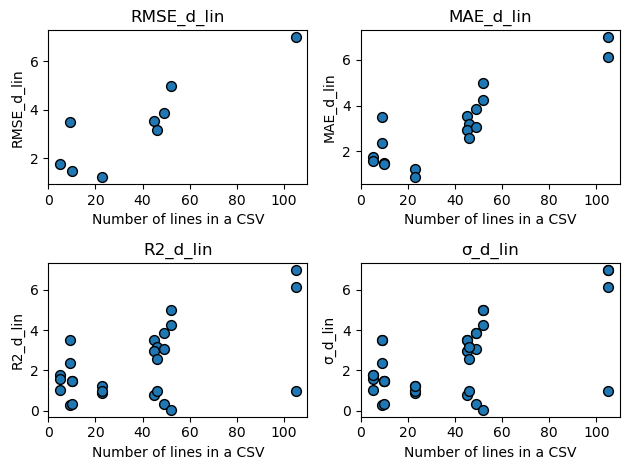

In [56]:
lens, errors = [], []
summary
i=0
for key in summary[0].keys():
    if 'd_lin' not in key:
        continue
    i+=1
    for s in summary:
        if s['len'] > 200:
            continue
        lens.append(s['len'])
        errors.append(s[key]) 
    plt.subplot(2,2,i)
    plt.scatter(lens, errors, s=50, c='C0', edgecolor='k')
    plt.title(key)
    plt.xlabel('Number of lines in a CSV')
    plt.ylabel(key )
plt.tight_layout()
plt.show()

## ------------------ Other models

| Legend label                  | Description                                                                                                                     |
|:------------------------------|:--------------------------------------------------------------------------------------------------------------------------------|
| **Measured distances**        | Blue markers: raw `bird_distance` ground-truth from the CSV.                                                                   |
| **Depth – Linear Regression** | Ordinary least squares \(d = a\,z + b\). Fast but assumes perfect linearity and is sensitive to outliers.                     |
| **Depth – Quadratic + Huber** | Polynomial + Huber: \(d = a_2z^2 + a_1z + a_0\) fitted with Huber loss** (quadratic if \(|r|\le\delta\), linear if \(|r|>\delta\)). |
| **Time – Linear Regression**  | Constant‐speed model \(d = v_0 + v_1\,t\). Cannot capture acceleration or errant frames.                                       |
| **Time – Quadratic + Huber**  | Polynomial + Huber: \(d = p_2t^2 + p_1t + p_0\) with the same robust Huber loss to tolerate frame outliers.                    |


** The Huber loss behaves like squared‐error for small residuals but switches to absolute‐error for large ones—so any calibration points with very large errors (outliers) only pull on the fit line proportionally, rather than quadratically. This makes the model both flexible (via the quadratic term) and robust (via Huber’s outlier down-weighting).


In [57]:
import pandas as pd
from IPython.display import Markdown, display

# 1) Read the wide-format CSV
wide = pd.read_csv('model_errors.csv')

# 2) Melt it into long format, one row per (file, model)
mappings = [
    ('Depth – Linear',            'd_lin'),
    ('Depth – Quadratic + Huber', 'd_hub'),
    ('Time – Linear',             't_lin'),
    ('Time – Quadratic + Huber',  't_hub'),
]


records = []
for label, prefix in mappings:
    dfm = wide[[
        'file',
        f'RMSE_{prefix}',
        f'MAE_{prefix}',
        f'R2_{prefix}',
        f'σ_{prefix}'
    ]].copy()
    dfm.columns = ['file','RMSE','MAE','R2','sigma']
    dfm['model'] = label
    records.append(dfm)

errors_long = pd.concat(records, ignore_index=True)


# Compute mean of each metric by model
df_model_avg = (
    errors_long
      .groupby('model')[['RMSE','MAE','R2','sigma']]
      .mean(numeric_only=True)
      .reset_index()
)

# 3) Display the one‐row‐per‐method summary
print("Average of each metric by model, across all files:")
display(Markdown(df_model_avg.to_markdown(index=False, floatfmt=".3f")))

# print nice separator
print("\n" + "="*120 + "\n")

# 4) Display the full table of every file × every model
print("Errors for each model, per file (INDIVIDUALLY):")
display(Markdown(errors_long.to_markdown(index=False, floatfmt=".3f")))


Average of each metric by model, across all files:


| model                     |   RMSE |    MAE |    R2 |   sigma |
|:--------------------------|-------:|-------:|------:|--------:|
| Depth – Linear            |  3.384 |  2.790 | 0.596 |   3.384 |
| Depth – Quadratic + Huber |  3.284 |  2.572 | 0.621 |   3.254 |
| Time – Linear             | 13.534 | 10.589 | 0.297 |  13.534 |
| Time – Quadratic + Huber  | 12.745 |  8.538 | 0.399 |  12.659 |



Errors for each model, per file (INDIVIDUALLY):


| file                                                             |    RMSE |     MAE |      R2 |   sigma | model                     |
|:-----------------------------------------------------------------|--------:|--------:|--------:|--------:|:--------------------------|
| 10-10-2024_06-56-26_track_246_cam_0.avi_track_242_cam_3.avi.csv  | nan     | nan     | nan     | nan     | Depth – Linear            |
| 10-10-2024_07-14-32_track_248_cam_0.avi_track_247_cam_4.avi.csv  |   6.986 |   6.121 |   0.971 |   6.986 | Depth – Linear            |
| 10-10-2024_07-50-59_track_251_cam_0.avi_track_249_cam_5.avi.csv  |   1.229 |   0.868 |   0.996 |   1.229 | Depth – Linear            |
| 10-10-2024_08-25-21_track_257_cam_0.avi_track_252_cam_8.avi.csv  |   3.521 |   2.345 |   0.268 |   3.521 | Depth – Linear            |
| 10-10-2024_08-31-27_track_262_cam_0.avi_track_258_cam_9.avi.csv  |   3.527 |   2.939 |   0.757 |   3.527 | Depth – Linear            |
| 10-10-2024_08-57-19_track_273_cam_0.avi_track_263_cam_11.avi.csv | nan     | nan     | nan     | nan     | Depth – Linear            |
| 10-10-2024_08-58-04_track_274_cam_0.avi_track_274_cam_12.avi.csv |   3.859 |   3.069 |   0.316 |   3.859 | Depth – Linear            |
| 10-10-2024_09-02-35_track_275_cam_0.avi_track_275_cam_13.avi.csv |   3.176 |   2.574 |   0.985 |   3.176 | Depth – Linear            |
| 10-10-2024_09-36-02_track_284_cam_0.avi_track_280_cam_15.avi.csv |   3.306 |   2.711 |   0.291 |   3.306 | Depth – Linear            |
| 10-10-2024_09-43-42_track_287_cam_0.avi_track_285_cam_16.avi.csv | nan     | nan     | nan     | nan     | Depth – Linear            |
| 10-10-2024_10-31-25_track_308_cam_0.avi_track_307_cam_26.avi.csv |   4.988 |   4.253 |   0.044 |   4.988 | Depth – Linear            |
| 10-10-2024_10-34-38_track_311_cam_0.avi_track_309_cam_27.avi.csv |   1.760 |   1.561 |   0.998 |   1.760 | Depth – Linear            |
| 10-10-2024_16-36-18_track_416_cam_0.avi_track_345_cam_39.avi.csv | nan     | nan     | nan     | nan     | Depth – Linear            |
| 10-10-2024_17-23-50_track_456_cam_0.avi_track_455_cam_61.avi.csv | nan     | nan     | nan     | nan     | Depth – Linear            |
| 10-10-2024_17-32-01_track_467_cam_0.avi_track_460_cam_69.avi.csv |   1.485 |   1.461 |   0.333 |   1.485 | Depth – Linear            |
| AVERAGE                                                          |   3.384 |   2.790 |   0.596 |   3.384 | Depth – Linear            |
| 10-10-2024_06-56-26_track_246_cam_0.avi_track_242_cam_3.avi.csv  | nan     | nan     | nan     | nan     | Depth – Quadratic + Huber |
| 10-10-2024_07-14-32_track_248_cam_0.avi_track_247_cam_4.avi.csv  |   6.882 |   6.041 |   0.972 |   6.880 | Depth – Quadratic + Huber |
| 10-10-2024_07-50-59_track_251_cam_0.avi_track_249_cam_5.avi.csv  |   1.093 |   0.653 |   0.997 |   1.076 | Depth – Quadratic + Huber |
| 10-10-2024_08-25-21_track_257_cam_0.avi_track_252_cam_8.avi.csv  |   2.988 |   1.895 |   0.473 |   2.917 | Depth – Quadratic + Huber |
| 10-10-2024_08-31-27_track_262_cam_0.avi_track_258_cam_9.avi.csv  |   3.264 |   2.501 |   0.797 |   3.260 | Depth – Quadratic + Huber |
| 10-10-2024_08-57-19_track_273_cam_0.avi_track_263_cam_11.avi.csv | nan     | nan     | nan     | nan     | Depth – Quadratic + Huber |
| 10-10-2024_08-58-04_track_274_cam_0.avi_track_274_cam_12.avi.csv |   3.931 |   2.925 |   0.291 |   3.913 | Depth – Quadratic + Huber |
| 10-10-2024_09-02-35_track_275_cam_0.avi_track_275_cam_13.avi.csv |   3.075 |   2.414 |   0.986 |   3.075 | Depth – Quadratic + Huber |
| 10-10-2024_09-36-02_track_284_cam_0.avi_track_280_cam_15.avi.csv |   3.248 |   2.581 |   0.321 |   3.223 | Depth – Quadratic + Huber |
| 10-10-2024_09-43-42_track_287_cam_0.avi_track_285_cam_16.avi.csv | nan     | nan     | nan     | nan     | Depth – Quadratic + Huber |
| 10-10-2024_10-31-25_track_308_cam_0.avi_track_307_cam_26.avi.csv |   4.994 |   4.230 |   0.042 |   4.988 | Depth – Quadratic + Huber |
| 10-10-2024_10-34-38_track_311_cam_0.avi_track_309_cam_27.avi.csv |   1.878 |   1.021 |   0.998 |   1.719 | Depth – Quadratic + Huber |
| 10-10-2024_16-36-18_track_416_cam_0.avi_track_345_cam_39.avi.csv | nan     | nan     | nan     | nan     | Depth – Quadratic + Huber |
| 10-10-2024_17-23-50_track_456_cam_0.avi_track_455_cam_61.avi.csv | nan     | nan     | nan     | nan     | Depth – Quadratic + Huber |
| 10-10-2024_17-32-01_track_467_cam_0.avi_track_460_cam_69.avi.csv |   1.485 |   1.461 |   0.333 |   1.485 | Depth – Quadratic + Huber |
| AVERAGE                                                          |   3.284 |   2.572 |   0.621 |   3.254 | Depth – Quadratic + Huber |
| 10-10-2024_06-56-26_track_246_cam_0.avi_track_242_cam_3.avi.csv  | nan     | nan     | nan     | nan     | Time – Linear             |
| 10-10-2024_07-14-32_track_248_cam_0.avi_track_247_cam_4.avi.csv  |  40.929 |  26.088 |   0.010 |  40.929 | Time – Linear             |
| 10-10-2024_07-50-59_track_251_cam_0.avi_track_249_cam_5.avi.csv  |  12.387 |  10.192 |   0.555 |  12.387 | Time – Linear             |
| 10-10-2024_08-25-21_track_257_cam_0.avi_track_252_cam_8.avi.csv  |   4.050 |   3.235 |   0.031 |   4.050 | Time – Linear             |
| 10-10-2024_08-31-27_track_262_cam_0.avi_track_258_cam_9.avi.csv  |   6.176 |   5.273 |   0.293 |   6.176 | Time – Linear             |
| 10-10-2024_08-57-19_track_273_cam_0.avi_track_263_cam_11.avi.csv | nan     | nan     | nan     | nan     | Time – Linear             |
| 10-10-2024_08-58-04_track_274_cam_0.avi_track_274_cam_12.avi.csv |   3.841 |   3.164 |   0.328 |   3.841 | Time – Linear             |
| 10-10-2024_09-02-35_track_275_cam_0.avi_track_275_cam_13.avi.csv |  22.742 |  19.320 |   0.227 |  22.742 | Time – Linear             |
| 10-10-2024_09-36-02_track_284_cam_0.avi_track_280_cam_15.avi.csv |   4.727 |   3.627 |   0.306 |   4.727 | Time – Linear             |
| 10-10-2024_09-43-42_track_287_cam_0.avi_track_285_cam_16.avi.csv | nan     | nan     | nan     | nan     | Time – Linear             |
| 10-10-2024_10-31-25_track_308_cam_0.avi_track_307_cam_26.avi.csv |   4.406 |   3.825 |   0.211 |   4.406 | Time – Linear             |
| 10-10-2024_10-34-38_track_311_cam_0.avi_track_309_cam_27.avi.csv |  35.799 |  30.933 |   0.253 |  35.799 | Time – Linear             |
| 10-10-2024_16-36-18_track_416_cam_0.avi_track_345_cam_39.avi.csv | nan     | nan     | nan     | nan     | Time – Linear             |
| 10-10-2024_17-23-50_track_456_cam_0.avi_track_455_cam_61.avi.csv | nan     | nan     | nan     | nan     | Time – Linear             |
| 10-10-2024_17-32-01_track_467_cam_0.avi_track_460_cam_69.avi.csv |   0.286 |   0.227 |   0.756 |   0.286 | Time – Linear             |
| AVERAGE                                                          |  13.534 |  10.589 |   0.297 |  13.534 | Time – Linear             |
| 10-10-2024_06-56-26_track_246_cam_0.avi_track_242_cam_3.avi.csv  | nan     | nan     | nan     | nan     | Time – Quadratic + Huber  |
| 10-10-2024_07-14-32_track_248_cam_0.avi_track_247_cam_4.avi.csv  |  37.809 |  22.774 |   0.155 |  37.380 | Time – Quadratic + Huber  |
| 10-10-2024_07-50-59_track_251_cam_0.avi_track_249_cam_5.avi.csv  |  11.147 |   7.636 |   0.667 |  10.976 | Time – Quadratic + Huber  |
| 10-10-2024_08-25-21_track_257_cam_0.avi_track_252_cam_8.avi.csv  |   3.985 |   3.112 |   0.062 |   3.916 | Time – Quadratic + Huber  |
| 10-10-2024_08-31-27_track_262_cam_0.avi_track_258_cam_9.avi.csv  |   5.542 |   4.399 |   0.441 |   5.513 | Time – Quadratic + Huber  |
| 10-10-2024_08-57-19_track_273_cam_0.avi_track_263_cam_11.avi.csv | nan     | nan     | nan     | nan     | Time – Quadratic + Huber  |
| 10-10-2024_08-58-04_track_274_cam_0.avi_track_274_cam_12.avi.csv |   3.229 |   2.539 |   0.457 |   3.222 | Time – Quadratic + Huber  |
| 10-10-2024_09-02-35_track_275_cam_0.avi_track_275_cam_13.avi.csv |  19.360 |  15.240 |   0.440 |  19.298 | Time – Quadratic + Huber  |
| 10-10-2024_09-36-02_track_284_cam_0.avi_track_280_cam_15.avi.csv |   4.160 |   2.909 |   0.453 |   4.123 | Time – Quadratic + Huber  |
| 10-10-2024_09-43-42_track_287_cam_0.avi_track_285_cam_16.avi.csv | nan     | nan     | nan     | nan     | Time – Quadratic + Huber  |
| 10-10-2024_10-31-25_track_308_cam_0.avi_track_307_cam_26.avi.csv |   3.869 |   2.571 |   0.373 |   3.842 | Time – Quadratic + Huber  |
| 10-10-2024_10-34-38_track_311_cam_0.avi_track_309_cam_27.avi.csv |  38.086 |  24.032 |   0.154 |  38.051 | Time – Quadratic + Huber  |
| 10-10-2024_16-36-18_track_416_cam_0.avi_track_345_cam_39.avi.csv | nan     | nan     | nan     | nan     | Time – Quadratic + Huber  |
| 10-10-2024_17-23-50_track_456_cam_0.avi_track_455_cam_61.avi.csv | nan     | nan     | nan     | nan     | Time – Quadratic + Huber  |
| 10-10-2024_17-32-01_track_467_cam_0.avi_track_460_cam_69.avi.csv |   0.265 |   0.171 |   0.791 |   0.265 | Time – Quadratic + Huber  |
| AVERAGE                                                          |  12.745 |   8.538 |   0.399 |  12.659 | Time – Quadratic + Huber  |

In [58]:
dfDistance = pd.read_csv(CSV)
# for track_id in dfDistance['track_id'].unique():
bMask = dfDistance['track_id']==track_id

mean_distance = LinearRegression()
mean_distance.fit([[t] for t in time],[[d] for d in bird_distances] )

ref_depth_values = []
ref_distance_values = []
red_ignore = []
new_distances = []
new_distances_125 = []
for i, track in dfDistance.iterrows():
    ref_depth_values.append( [aaa[0] for aaa in eval(track['ref_depth_values'].replace('\n',','))] )
    ref_distance_values.append( eval(
        str(re.sub(r'\s+| ',',',track['ref_distance_values'])).replace('[,','[')
        ))
    distanceLR = LinearRegression().fit(np.reshape(ref_depth_values[-1],(-1,1)),
                                        np.reshape(ref_distance_values[-1],(-1,1)))
    
max_distance = max([max(a) for a in ref_distance_values])
min_distance = min([min(a) for a in ref_distance_values])

    # new_distance = track['bird_Depth']*distanceLR.coef_[0] + distanceLR.intercept_
    # new_distances.append(new_distance[0])
    # new_distances_125.append(125*distanceLR.coef_[0] + distanceLR.intercept_)
    # print(track['bird_distance'], new_distance)

bMask = dfDistance['track_id']==track_id
bird_distances = dfDistance['bird_distance']
bird_depths = dfDistance[bMask]['bird_Depth']
time = dfDistance[bMask]['current_frame']/FPS
# distance for depth = 125

bMask_ignore = [True if dist>min_distance and dist<max_distance and not ig else False for (ig, dist) in zip(dfDistance['ignore'],dfDistance['bird_distance'])]
filtered_bird_distances = bird_distances[bMask_ignore]
filtered_time = time[bMask_ignore]

mean_distance_new = LinearRegression()
mean_distance_new.fit([[t] for t in filtered_time],[[d] for d in filtered_bird_distances] )


print(dfDistance['ref_circles'].unique())
# print(bird_distances)
plot.plot(time,bird_distances)
# plot.plot(time,bird_depths)
plot.plot(pd.concat([time.loc[dfDistance['ignore'].map(bool)],time.loc[bird_distances>max_distance],time.loc[bird_distances<min_distance]]),
         pd.concat([bird_distances.loc[dfDistance['ignore'].map(bool)],bird_distances.loc[bird_distances>max_distance],bird_distances.loc[bird_distances<min_distance]]),
                         'r*')
# plot.plot(time, new_distances)
# plot.plot(time, vector_distance125)
plot.plot(time, mean_distance.predict([[t] for t in time]),':')
plot.plot(time, mean_distance_new.predict([[t] for t in time]))

plot.plot(time, max_distance*np.ones(len(time)), 'k--')
plot.plot(time, min_distance*np.ones(len(time)), 'k--')
plot.legend(["Distancia",
             "Valores ignorados","Regressão com todos valores",'Regressão com valores filtrados',
             'max','min'],loc='upper left')
plot.xlabel('time [s]')
plot.ylabel('Distance from camera [m]')
plot.ylim([0,400])
plot.title("Distance versus time on video " + CSV.split('\\')[-1][:-4])
plot.show()

residuals = filtered_bird_distances - mean_distance_new.predict([[t] for t in filtered_time]).reshape(-1)
std_dev_residuals = np.std(residuals)
residuals_old = filtered_bird_distances - mean_distance.predict([[t] for t in filtered_time]).reshape(-1)
residuals_old = bird_distances - mean_distance.predict([[t] for t in time]).reshape(-1)
std_dev_residuals_old = np.std(residuals_old)
print("Desvio padrão:", round(std_dev_residuals,2), "m")
print("Desvio padrão antigo:", round(std_dev_residuals_old,2), "m")

IndexError: Boolean index has wrong length: 124 instead of 0

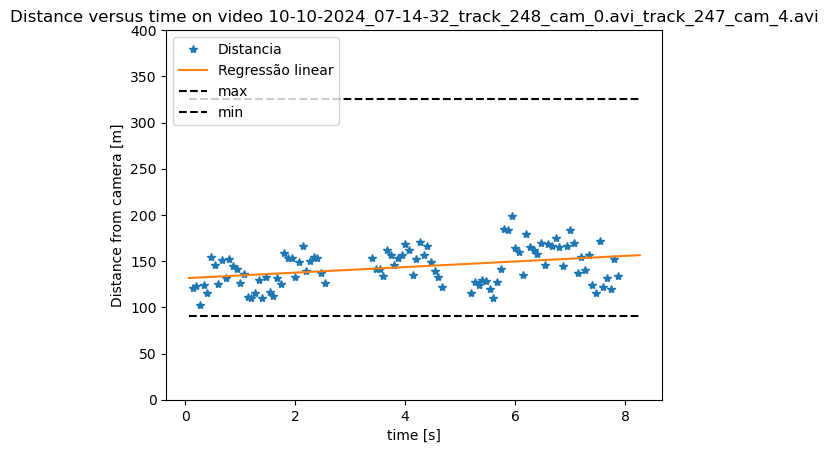

In [ ]:
plot.plot(filtered_time,filtered_bird_distances,'*')
plot.plot(time, mean_distance_new.predict([[t] for t in time]))

plot.plot(time, max_distance*np.ones(len(time)), 'k--')
plot.plot(time, min_distance*np.ones(len(time)), 'k--')
plot.legend(["Distancia",
             'Regressão linear',
             'max','min'],loc='upper left')
plot.xlabel('time [s]')
plot.ylabel('Distance from camera [m]')
plot.ylim([0,400])
plot.title("Distance versus time on video " + CSV.split('\\')[-1][:-4])
plot.show()

In [ ]:
# np.concatenate(time.loc[dfDistance['ignore'].map(bool)],
time.loc[bird_distances>max_distance]
pd.concat([time.loc[bird_distances<min_distance], time.loc[bird_distances>max_distance]]
)

0      0.066667
41     2.800000
42     2.866667
74     5.000000
75     5.066667
118    7.933333
119    8.000000
120    8.066667
121    8.133333
122    8.200000
123    8.266667
Name: current_frame, dtype: float64

In [ ]:
dfDistance.sort_values('bird_distance',ascending=False).head(2)

,Unnamed: 0,coordinates_x1,coordinates_y1,coordinates_x2,coordinates_y2,current_frame,track_id,video_file,bird_distance,bird_Depth,coefs,ref_depth_values,ref_distance_values,ref_choosen_points,ref_circles,ignore
88,88,1366.860107,524.858032,1425.249268,557.036865,89.0,134.0,10-10-2024_07-14-32_track_248_cam_0.avi_track_...,199.15594,2.917859,"[array([-61.93826], dtype=float32), 379.88306]",[[4.5554786]\n [3.6012373]\n [2.3165092]\n [2....,[ 97.03452097 132.67746731 182.81089 238.42...,[],10-10-2024_09-02-35_track_275_cam_0.png,0
86,86,1337.560791,521.164368,1396.021729,555.755188,87.0,134.0,10-10-2024_07-14-32_track_248_cam_0.avi_track_...,184.40092,3.185091,"[array([-61.661144], dtype=float32), 380.7973]",[[4.539402 ]\n [3.5691998]\n [2.3147368]\n [2....,[ 97.03452097 132.67746731 182.81089 238.42...,[],10-10-2024_09-02-35_track_275_cam_0.png,0


In [ ]:
dfDistance.columns

Index(['Unnamed: 0', 'coordinates_x1', 'coordinates_y1', 'coordinates_x2',
       'coordinates_y2', 'current_frame', 'track_id', 'video_file',
       'bird_distance', 'bird_Depth', 'coefs', 'ref_depth_values',
       'ref_distance_values', 'ref_choosen_points', 'ref_circles', 'ignore'],
      dtype='object')

In [ ]:
dsDepths = dfDistance['ref_depth_values'].map(lambda x: [aaa[0] for aaa in eval(x.replace('\n','').replace('[ ','[').replace(' ',','))]  )

i = 0
for i in range(5):
    sns.histplot(dsDepths.map(lambda x: x[i]),binrange=(0,255))

SyntaxError: invalid syntax (<string>, line 1)

c:\Users\plima\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\plima\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='coefs', ylabel='Count'>

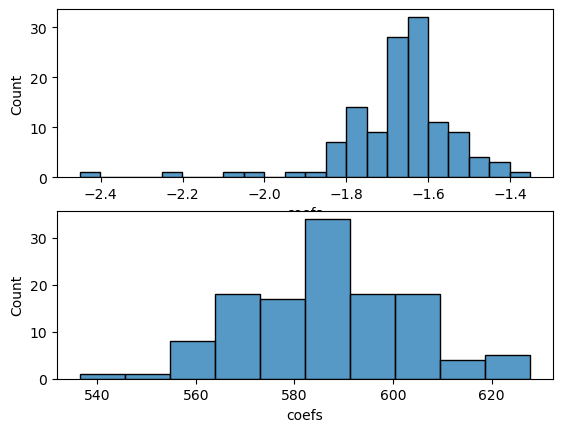

In [ ]:

coefs = dfDistance['coefs'].map(lambda x: eval(x.split(']')[0].split('[')[-1]))
interceps = dfDistance['coefs'].map(lambda x: eval(x.split(']')[-2].split(' ')[-1]))

plot.subplot(211)
sns.histplot(coefs)
plot.subplot(212)
sns.histplot(interceps)

# Criar video

In [ ]:
import cv2

In [ ]:
num_frame = 111
total_frames = len(glob.glob('./results/'+dfDistance['video_file'][0].replace('.avi','')[:20]+'*0.png'))

video=cv2.VideoWriter( dfDistance['video_file'][0].replace('.avi','_depth.mp4')
                      ,cv2.VideoWriter_fourcc(*'MP4V'),6,(2300,1350)) #,fps=15.0)
# (1350, 2300, 3)
# print(video)

for i in range(total_frames):
    num_frame = i+1

    # fix problem ordering 1 and 11 and 111:
    filename = glob.glob('./results/'+dfDistance['video_file'][0].replace('.avi','')[:20]+'*' + str(num_frame) + '.0.png')[0]

    frame = cv2.imread(filename)
    # print(frame.shape )
    # print(cropped_img.shape)

    cropped_img = frame[400:1750, 4200:6500]
    # cv2.imshow('teste',cropped_img)
    # cv2.waitKey()
    # cv2.destroyAllWindows()
    # print(cropped_img.shape)

    video.write(cropped_img)
    print(i+1,"from ", total_frames , end='\r')
video.release()